# CS352 Machine Learning Coursework

## A: Feature Extraction & Bayes Classifier

### A.1: Extracting, Sampling and Training

**Overview:**

In this section, the CelebA dataset is prepared for use with a Gaussian Naive Bayes classifer. The task invovles three main steps: selecting and sampling images, extracting fixed feature emebeddings using a pre-trained model and finally splitting the data for training.

**Components Used:**

- **Dataset loading and sampling**: Selects 20,000 images from the folder provided and aligns them with their corresponding labels in the CelebA attributes file.
- `ImageDataset` **class**: Custom PyTorch dataset class for loading and preprocessing the images.
- **Preprocessing**: A preprocessing transformation is applied to the images to prepare them for the Vision Transformer.
- `extractFeatures` **function**:  Uses a `create_feature_extractor` to run all sampled images through a pre-trained ViT-B/16 model and produces a 768 dimensional feature vector for each image.
- **Partitioning**: Numpy is used to partition the extracted features into training, calibration and testing sets.

All required libraries for the project are imported here.

In [89]:
import numpy as np
import pandas as pd
import torch
import os
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import HTML, display
from sklearn.calibration import CalibratedClassifierCV, FrozenEstimator
from sklearn.base import BaseEstimator, ClassifierMixin

The global variables used throughout the project are defined.

In [90]:
# Directory of images to be trained
IMAGE_DIR = "celeba_selection"

# File location of the image attribute file
ATTRIBUTE_FILE = "list_attr_celeba.txt"

# Number of images to be sampled
SAMPLE_SIZE = 20000

# For part C we are only concerned with these image attributes
SELECTED_ATTRIBUTES = ["Smiling", "Male", "Young", "Blond_Hair", "Wearing_Hat"]

# To speed up feature extraction, perform it in batches. If low VRAM, lower this number
BATCH_SIZE = 32

# Attribute for Part A and B
PREDICTION_ATTRIBUTE = "Smiling"

# If you want to re-extract on a new set of images set this to True
RESET = False

# Set to true to enable random partitioning of data
RANDOM = True

# Set the random seed to a constant so its repeatable across runs
np.random.seed(38)

# Percentage of images that are part of the training set
TRAINING_PERCENT = 0.7

# Percentage of images that are part of the calibration set
CALIB_PERCENT = 0.15

# The file location of extracted features cache
EMBEDDINGS_FILE = "extracted_features.npz"

# Number of bins for graphs
NUMBINS = 10

# Wrapper HTML for output messages
MESSAGE_PREFIX = ("""
    <div style="background-color: #232136; color: #E0DEF4; width: fit-content; 
    font-size: 20px; font-family: \'Trebuchet MS\', sans-serif; 
    padding: 15px; margin: 0px; border-radius: 5px; box-shadow: 1px 1px 3px rgba(0,0,0,0.1)">"""
)
MESSAGE_SUFFIX = "</div>"

# Colour pallette for graphs
COLOURS = {
    "background": "#232136",
    "text": "#e0def4",
    "grid": "#393552",
    "perfect": "#908CAA",
    "empirical": "#eb6f92",
    "fit1": "#3e8fb0",
    "fit2": "#9ccfd8",
    "fit3": "#c4a7e7"
}

# Set global matplotlib style
plt.style.use("dark_background")
rcParams["figure.facecolor"] = COLOURS["background"]
rcParams["axes.facecolor"] = COLOURS["background"]
rcParams["axes.edgecolor"] = COLOURS["grid"]
rcParams["axes.labelcolor"] = COLOURS["text"]
rcParams["text.color"] = COLOURS["text"]
rcParams["xtick.color"] = COLOURS["text"]
rcParams["ytick.color"] = COLOURS["text"]
rcParams["grid.color"] = COLOURS["grid"]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Trebuchet MS", "Arial", "DejaVu Sans"]
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 14
rcParams["axes.labelsize"] = 12
rcParams["legend.fontsize"] = 10

This loads a subset of CelebA image filenames from the given directory and retrieves their corresponding attribute labels.

In [91]:
# Load subset of image filenames to be analysed
sampledImageFiles = os.listdir(IMAGE_DIR)[:SAMPLE_SIZE]

if len(sampledImageFiles) != SAMPLE_SIZE:
    raise Exception(f"Error: Not enough images ({SAMPLE_SIZE}) in the folder ({len(sampledImageFiles)})")

# Load attribute file and load selected columns for part C
attributeData = pd.read_csv(
    ATTRIBUTE_FILE,
    sep=r"\s+",
    header=1,
    index_col=0
)[SELECTED_ATTRIBUTES]

# Link each entry in the attribute file to their corresponding image name
sampledAttributes = attributeData.loc[sampledImageFiles]

This below code blocks define a PyTorch dataset class for loading images and a function for extracting Vision Transformer ViT features from those images.

In [92]:
class ImageDataset(Dataset):
    """
    A custom PyTorch Dataset for loading images from a directory.

    Attributes:
        imageNames (list): List of image filenames to load.
        imageDir (str): Path to the directory containing the image files.
        transform (callable, optional): Optional torchvision transform to apply to images.
    """

    def __init__(self, imageNames, imageDir, transform=None):
        """
        Initialise the dataset. 

        Args:
            imageNames (list): List of image filenames to load.
            imageDir (str): Path to the directory containing the image files.
            transform (callable, optional): Optional torchvision transform to apply to images.
        """
        self.imageNames = imageNames
        self.imageDir = imageDir
        self.transform = transform

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: NUmber of image filenames stored.
        """
        return len(self.imageNames)
    
    def __getitem__(self, index):
        """
        Load and return a transformed image at the given index.

        Args:
            index (int): Index of the desired image.

        Returns:
            Tensor: The transformed image tensor.
        """
        if self.transform:
            img = Image.open(os.path.join(self.imageDir, self.imageNames[index])).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img
        

In [93]:
def extractFeatures(sampledImageFiles, loader, embeddingsFile=EMBEDDINGS_FILE, reset=RESET):
    """
    Extract ViT feature embeddings for a set of images.

    Args:
        sampledImageFiles (list): List of image filenames used in the dataset.
        loader (DataLoader): PyTorch Dataloader for batching image inputs.
        embeddingsFile(str): Path to the .npz file for caching embeddings.
        reset (bool): If True, forces re-extraction even if cached embeddings exist.

    Returns:
        numpy.ndarray: An array of extracted feature vectors.
    """

    # Check for cached embeddings file
    if not reset and os.path.exists(embeddingsFile):

        data = np.load(embeddingsFile)

        savedImageNames = data["imageNames"]

        # If image list in embeddings is not equal to embeddings file then re-extract with new list
        if len(savedImageNames) == len(sampledImageFiles) and  np.array_equal(savedImageNames, sampledImageFiles):
            
            display(HTML(MESSAGE_PREFIX + "Embeddings match sampled image list. Skipping extraction." + MESSAGE_SUFFIX))
            
            return data["embeddings"]
        

    # Load the pretrained ViT model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
    vit.eval()

    # Create feature extractor to retrieve encoder outputs
    featureExtractor = create_feature_extractor(vit, return_nodes={"encoder": "features"})
    allFeatures = []

    # Extract features with no gradient tracking
    with torch.no_grad():

        with tqdm(total=len(loader.dataset), desc="Extracting ViT Features", colour="#EBBCBA") as pbar:
        
            for batch in loader:
        
                batch = batch.to(device)
                features = featureExtractor(batch)["features"][:, 0] # CLS token
                allFeatures.append(features.cpu()) # Append still on GPU, avoid per-batch CPU transfer
                torch.cuda.empty_cache()

                # Update progress bar by number of images in the batch
                pbar.update(batch.size(0))

    # Convert list of tensors into one NumPy array
    allFeaturesNP = torch.cat(allFeatures, dim=0).cpu().numpy() # Single .cpu() call
    display(HTML(MESSAGE_PREFIX + f"Feature matrix shape: {allFeaturesNP.shape}" + MESSAGE_SUFFIX))


    np.savez(embeddingsFile, embeddings=allFeaturesNP, imageNames=np.array(sampledImageFiles))
    display(HTML(MESSAGE_PREFIX + f"Embeddings + image names saved to '{embeddingsFile}'." + MESSAGE_SUFFIX))

    return allFeaturesNP

Once classes and functions have been defined, the features can be loaded and used for future use in the project.

In [94]:
# Preprocessing: resize, crop, convert to tensor, normalise for ViT
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset with preprocessing
dataset = ImageDataset(sampledImageFiles, IMAGE_DIR, transform=preprocess)

# Create DataLoader for batch processing
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Extract ViT embeddings for all images
allFeaturesNP = extractFeatures(sampledImageFiles, loader)

Now that features have been extracted and loaded, the target attributes are converted to binary labels between 0 and 1 so they will work within the Gaussian Naive Bayes classifier. Then the dataset is randomly split into the three partitions: training, calibration and testing.

In [95]:

# Convert target attribute from {-1, 1} to {0, 1}
labelsAll = ((sampledAttributes + 1) // 2)
labels = labelsAll["Smiling"].values
# Compute sizes for training and calibration sets
trainSize = int(TRAINING_PERCENT * SAMPLE_SIZE)
calibSize = int(CALIB_PERCENT * SAMPLE_SIZE)

# Create array of indices for all samples
indices = np.arange(SAMPLE_SIZE)

# Shuffle indices if RANDOM is True
if RANDOM:
    np.random.shuffle(indices)

# Split indices into the three partitions
trainIndex, calibIndex, testIndex = np.split(indices, [trainSize, trainSize + calibSize])

# Select feature embeddings and labels for each set
XTrain, yTrain = allFeaturesNP[trainIndex], labels[trainIndex]
XCalib, yCalib = allFeaturesNP[calibIndex], labels[calibIndex]
XTest, yTest = allFeaturesNP[testIndex], labels[testIndex]

### A.2: Training the Gaussian Naive Bayes Classifier

**Overview:**

In this section, a Gaussian Naive Bayes Classifier is trained using the feature embeddings extracted from the CelebA dataset. The model is then used to predict the "Smiling" attribute which the accuracy is then measured to determine the effectiveness of the GNB model.

**Components Used:**

- `GaussianNaiveBayes` **class**: Implements a GNB classifier with methods to train on data, compute log-probabilities and predict class labels. Inherits from BaseEstimator and ClassifierMixin to ensure compatability with part D.
- `train` **method**: Calculates class-specific means, variances and prior probabilities from the training features and labels using the following formulas:
  - **Mean:**  
  $$
  \mu_{c,i} = \frac{1}{N_c} \sum_{j=1}^{N_c} X_{j,i} \quad \text{for samples } X_j \text{ in class } c
  $$

  - **Variance:**  
  $$
  \sigma_{c,i}^2 = \frac{1}{N_c} \sum_{j=1}^{N_c} (X_{j,i} - \mu_{c,i})^2 + \epsilon
  $$
  where $\epsilon$ is a small constant added for numerical stability, in this case its $10^{-6}$

  - **Prior probability:**  
  $$
  P(c) = \frac{N_c}{N}
  $$

- `predictProbabilities` **method**: Computes the log-posterior for each class using the Gaussian probability density function:

  - **Log-likelihood for a feature vector \(X\):**  
  $$
  \log P(X|c) = \sum_{i=1}^{d} \log \frac{1}{\sqrt{2 \pi \sigma_{c,i}^2}} \exp\Big(-\frac{(X_i - \mu_{c,i})^2}{2 \sigma_{c,i}^2}\Big)
  $$

  - **Log-posterior:**  
  $$
  \log P(c|X) \propto \log P(X|c) + \log P(c)
  $$

  - **Class probabilities (softmax):**  
  $$
  P(c|X) = \frac{\exp(\log P(c|X))}{\sum_{c"} \exp(\log P(c"|X))}
  $$

- `predict` **method**: Predicts the class with the highest posterior probability:

$$
\hat{y} = \arg\max_c P(c|X)
$$

- **Training and evaluation**: The model is trained on `XTrain` and `yTrain`, then tested on `XTest` to obtain predictions and compute test accuracy:

$$
\text{Accuracy} = \frac{\text{\# correct predictions}}{\text{total test samples}}
$$

The Gaussian Naive Bayes (GNB) class is defined here.

In [96]:
class GaussianNaiveBayes(ClassifierMixin, BaseEstimator):
    """
    GNB Classifier for multi-class data.

    Assumes conditional independence and that each feature follows a Gaussian (Normal) distribution.

    Attributes:
        classes_ (ndarray): Unique class labels.
        means (ndarray): Mean of each feature for each class.
        variances (ndarray): Variance of each feature for the class.
        priors (ndarray): Prior probabilities for each class.
    """
    
    _estimator_type = "classifier"

    def __init__(self):
        """
        Initalise the classifier, model parameters set to None.
        """
        self.classes_ = None
        self.means = None
        self.variances = None
        self.priors = None
    
    def _more_tags(self):
        """
        Provide additional tags for sklearn"s estimator checks.
        """
        return {"requires_y": True}


    def fit(self, X, y):
        """
        Train the Gaussian Naive Bayes classifier.

        Args:
            X (ndarray): Feature matrix of shape (numSamples, numFeatures).
            y (ndarray): Target labels of shape (numSamples,).
        
        Computes:
            - Class-specific means and variances for each feature.
            - Prior probabilities for each class.
        
        Returns:
            self: The fitted estimator.
        """

        # Identify all unique classes in the training data
        self.classes_ = np.unique(y)
        numFeatures = X.shape[1]

        # Initialise arrays to hold means, variances and priors
        self.means = np.zeros((len(self.classes_), numFeatures))
        self.variances = np.zeros((len(self.classes_), numFeatures))
        self.priors = np.zeros(len(self.classes_))

        # Compute statistics for each class
        for index, c in enumerate(self.classes_):
            
            # Select all samples belonging to class c
            Xc = X[y == c]

            # Compute mean and variance for each feature in this class
            self.means[index] = Xc.mean(axis=0)
            self.variances[index] = Xc.var(axis=0) + 1e-6

            # Compute prior probability of the class
            self.priors[index] = len(Xc) / len(X)
        
        return self

    
    def __log_gaussian_pdf(self, X, mean, variance):
        """
        Compute the log of the Gaussian Probability Density Function.

        Args:
            X (ndarray): Feature values.
            mean (ndarray): Mean values for each feature.
            variance (ndarray): Variances for each feature

        Returns:
            ndarray: Log-probability of X under a Gaussian distribution
        """
        return -0.5 * (np.log(2 * np.pi * variance) + ((X - mean) ** 2) / variance)


    def predict(self, X):
        """
        Predict class labels for input data.

        Args:
            X (ndarray): Feature matrix of shape (numSamples, numFeatures).

        Returns:
            ndarray: Predicted class labels.
        """

        # Compute class probabilities and select the class with maximum probability
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

        
    def predict_proba(self, X):
        """
        Compute class probabilitites for input data.

        Args:
            X (ndarray): Feature matrix of shape (numSamples, numFeatures).

        Returns:
            ndarray: Probability of each class for each sample.
        """

        logPosteriors = []

        # Compute log-posterior for each class
        for index in range(len(self.classes_)):
            mean = self.means[index]
            variance = self.variances[index]
            logPrior = np.log(self.priors[index])

            # Compute log-liklihood for all features and sum over features
            logLikelihood = np.sum(self.__log_gaussian_pdf(X, mean, variance), axis=1)

            # Log-posterior - log-liklihood + log-prior
            logPosteriors.append(logLikelihood + logPrior)

        # Stack log-posteriors for all classes (shape: numSamples x numClasses)
        logPosteriors = np.vstack(logPosteriors).T

        # Apply softmax to convert log-posteriors to probabilities
        maxLog = np.max(logPosteriors, axis=1, keepdims=True)
        expScores = np.exp(logPosteriors - maxLog)
        probabilities = expScores / np.sum(expScores, axis=1, keepdims=True)

        return probabilities

Now that the class has been defined we can use it to see how effective the naiive bayes classifier is for this dataset

In [97]:
gnb = GaussianNaiveBayes()
gnb.fit(XTrain, yTrain)
yPred = gnb.predict(XTest)
accuracy = np.mean(yPred == yTest)
display(HTML(MESSAGE_PREFIX + f"Accuracy: {accuracy:.4f}" + MESSAGE_SUFFIX))

## B: Population Calibration

### B.1 Computing predicted probabilitites

**Overview**:

In this section, the calibration of the GNB classifier is evaluated. Using the calibration set, we compute predicted probabiltities for the target class (*Smiling Faces*) and visualise how well these predicted probabilities correspond to actual outcomes using a reliability diagram.

**Components Used**:

- `predictProbabilities` **method**: Computes the predicted probability of each class for every sample in the calibration set (defined above).
- `generateBins` **function**:
    - Splits the predicted probabilities into a fixed number of bins (e.g., 10 bins from 0 to 1).
    - For each bin, computes: the average predicted probability (model confidence) and the average true label (empirical accuracy).
    - Returns these per-bin confidence and accuracy values, which are used to construct a reliability diagram or otherwise assess calibration quality.

The probabilities are calculated for *Smiling Faces* using the calibration set and reliability diagram is plotted.

In [98]:
def generateBins(trues, probs, numBins=NUMBINS):
    """
    Groups prediction probabilities into bins and computes
    average confidence and accuracy for each bin.

    Parameters:
        trues (ndarray): Ground-truth labels (0/1).
        probs (ndarray): Predicted probabilities (in [0, 1]).
        numBins (int): Number of bins to split the probabilities into.

    Returns:
        confidences (array): Mean predicted probability per bin.
        accuracies (array): Mean true label per bin (accuracy estimate).
    """

    # Create evenly spaced bins from 0 to 1
    binEdges = np.linspace(0, 1, numBins + 1)

    # Assign each probability to a bin
    binIndices = np.digitize(probs, binEdges) - 1

    # Prepare arrays for storing per bin values
    accuracies = np.zeros(numBins)
    confidences = np.zeros(numBins)

    for i in range(numBins):

        # Boolean mask selects all samples belonging to bin i
        inBin = (binIndices == i)
        count = np.sum(inBin)
    
        # If bin contains values find mean and set the bin value to the mean
        if count > 0:
            accuracies[i] = np.mean(trues[inBin])
            confidences[i] = np.mean(probs[inBin])
        
        # Otherwise set bin to NaN (Not a Number) so its not included
        else:
            accuracies[i] = np.nan
            confidences[i] = np.nan

    return confidences, accuracies

Now that the bin function has been defined it can be used to plot our reliability graph.

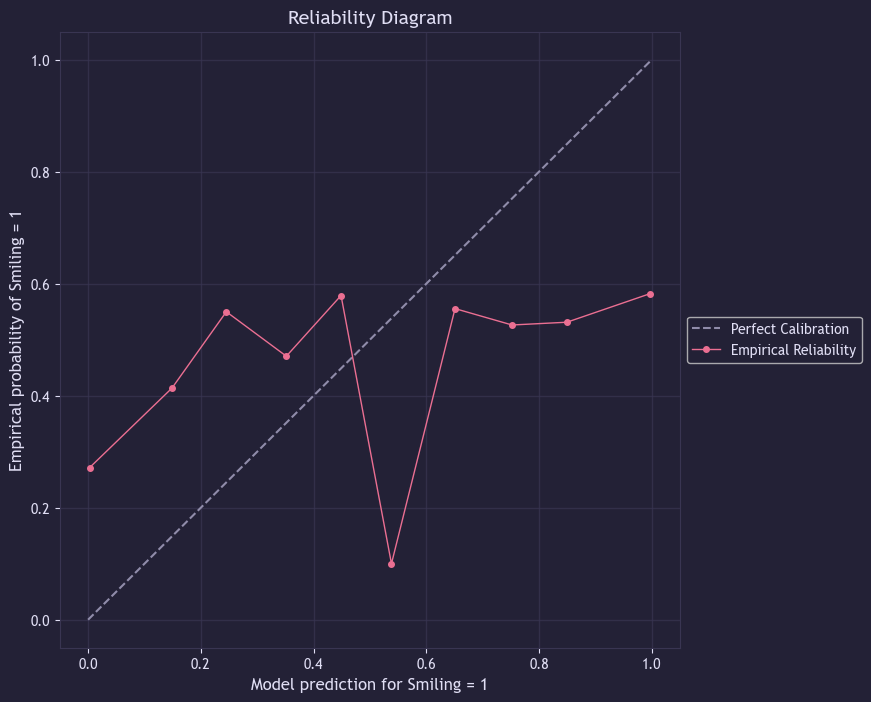

In [99]:
pCalib = gnb.predict_proba(XCalib)[:, 1]
confidences, accuracies = generateBins(yCalib, pCalib)

# Plot the reliability diagram
plt.figure(figsize=(8,8))

plt.plot([0,1],[0,1], label="Perfect Calibration", color=COLOURS["perfect"], linestyle="dashed")

# Empirical points
plt.plot(confidences, accuracies, marker="o", linestyle="-", color=COLOURS["empirical"], label="Empirical Reliability", markersize=4, linewidth=1)

plt.grid(True, alpha=0.7, linestyle="-", linewidth=1)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Model prediction for Smiling = 1")
plt.ylabel("Empirical probability of Smiling = 1")
plt.title("Reliability Diagram")
plt.show()

### B.2 Computing ECE 

**Overview**:

Here, the calibration of GNB is evaluated using the Expected Calibration Error (ECE) and Mean Squared Error (MSE) between practical probabilities and true outcomes to determine whether the model tends to be overconfident or underconfident.

**Components Used**:

- `computeECE` **function**: Calculates the ECE using binned probabilities.
- `computeMSE` **function**: Computes the mean squared error between predictions and true labels.
- `predictProbabilities` **method**: Used on calibration instnace of GNB to create the data used in the calculations.

We have to create the 2 functions that compute ECE and MSE.

In [100]:
def computeECE(yTrue, yProb, numBins=NUMBINS):
    """
    Compute Expected Calibration Error for probabilistic predictions.

    Args:
        yTrue (ndarray): True binary labels (0 or 1).
        yProb (ndarray): Predicted probabilities for the positive class.
        numBins (int): Number of bins to group predicted probabilities.

    Returns:
        float: ECE score
    """
    # Crate bin edges and assign predictions to bins
    binEdges = np.linspace(0, 1, numBins + 1) 
    binIndices = np.digitize(yProb, binEdges) - 1
    
    # Clip indices to ensure they are within [0, numBins-1]
    binIndices = np.clip(binIndices, 0, numBins - 1)

    # Initialise arrays for bin counts, mean accuracies and confidences
    counts = np.bincount(binIndices, minlength=numBins)

    # Avoid division by 0 by masking empty bins later
    binSumsTrue = np.bincount(binIndices, weights=yTrue, minlength=numBins)
    binSumsProb = np.bincount(binIndices, weights=yProb, minlength=numBins)

    # Compute mean accuracy and mean confidence per bin
    mask = counts > 0
    accuracies = np.zeros(numBins)
    confidences = np.zeros(numBins)
    accuracies[mask] = binSumsTrue[mask] / counts[mask]
    confidences[mask] = binSumsProb[mask] / counts[mask]

    # Compute ECE: weighted average of | accuracy - confidence |
    ece = np.sum((counts[mask] / len(yTrue)) * np.abs(accuracies[mask] - confidences[mask]))

    return ece

def computeMSE(yTrue, yProb):
    """
    Compute Mean Squared Error (MSE).

    Args:
        yTrue (ndarray): True binary labels (0 or 1)
        yProb (ndarray): Predicted probabilities for the positive class

    Returns:
        float: MSE score
    """
    return np.mean((yTrue - yProb) ** 2)


As the functions have now been generated we can compute the values based on the test data set.

In [101]:
pTest = gnb.predict_proba(XTest)[:, 1]
ece = computeECE(yTest, pTest)
mse = computeMSE(yTest, pTest)
resultsDF = pd.DataFrame({
    "Metric": ["ECE", "MSE"],
    "Value": [f"{ece:.4f}", f"{mse:.4f}"]
})
display(HTML(MESSAGE_PREFIX + resultsDF.to_html(index=False) + MESSAGE_SUFFIX))

Metric,Value
ECE,0.2846
MSE,0.2858


**Comment on Model Calibration**

The GNB classifier displays substantial miscalibration on the test set. This is reflected by the ECE being around 0.3, indicating that, on average, the model’s predicted confidence differs from the true empirical accuracy by roughly 29 percentage points. Such a high value shows that the classifier’s probability estimates are unreliable. The MSE of also around 0.3 reinforces this: because MSE penalises large deviations more strongly, it suggests that the model frequently outputs probabilities that are far from the actual outcomes.

The reliability diagram provides a visual confirmation of this behaviour. In many bins, particularly in the mid-range of predicted probabilities (0.4 to 0.7), the empirical accuracy consistently falls below the model’s predicted probabilities. The empirical points lie mostly beneath the diagonal line of perfect calibration, indicating that the model is overconfident: it assigns high probabilities to “Smiling = 1” even when the true frequency of smiling faces in those bins is considerably lower.

This outcome is not surprising for a Gaussian Naive Bayes classifier. GNB assumes conditional independence across all feature dimensions, an assumption that is unrealistic in high-dimensional visual embeddings such as those from a Vision Transformer. When these assumptions are violated, the resulting likelihoods can be poorly behaved, leading to probability estimates that are poorly calibrated.

Overall, the results clearly show that while the classifier may still perform reasonably in terms of classification accuracy, its probability predictions are not trustworthy, motivating the need for post-hoc calibration methods shown in later sections.

## C: Subgroup Calibration

### C.1: Plotting reliability, computing ECE, MSE for each subgroup & summary table

**Overview:**

This section evaluates GNB calibration across 8 subgroups (Male/Female, Young/Not Young, Blond_Hair/Not Blond_Hair, Wearing_Hat/Not Wearing_Hat) in the test set. Accuracy, ECE and MSE are computed per subgroup and reliability diagrams visualise how predicted probabilities align with actual outcomes. This identifies subgroups that are poorly calibrated, which may be hidden by summary metrics.

**Components Used:**

- `SUBGROUPS` **dictionary**: Boolean masks for each subgroup.
- `yTest`, `pTest`: True labels and predicted probabilties for the test set.
- `computeECE`, `computeMSE`: Functions to compute calibration errors.
- `generateBins` **function**: Creates the data needed for the plots.

First the subgroups are defined. They are defined in such a way where they can act as a mask for the dataset we already have.

In [102]:
SUBGROUPS = {
    "Male": {
        "description": "Male = 1",
        "mask": labelsAll["Male"] == 1
    },
    "Female": {
        "description": "Male = 0",
        "mask": labelsAll["Male"] == 0
    },
    "Young": {
        "description": "Young = 1",
        "mask": labelsAll["Young"] == 1
    },
    "Not Young": {
        "description": "Young = 0",
        "mask": labelsAll["Young"] == 0
    },
    "Blond_Hair": {
        "description": "Blond_Hair = 1",
        "mask": labelsAll["Blond_Hair"] == 1
    },
    "Not Blond_Hair": {
        "description": "Blond_Hair = 0",
        "mask": labelsAll["Blond_Hair"] == 0
    },
    "Wearing_Hat": {
        "description": "Wearing_Hat = 1",
        "mask": labelsAll["Wearing_Hat"] == 1
    },
    "Not Wearing_Hat": {
        "description": "Wearing_Hat = 0",
        "mask": labelsAll["Wearing_Hat"] == 0
    }
}

Next, the subgroups are looped through, where corresponding probabilities are extracted and plotted on the graphs below.

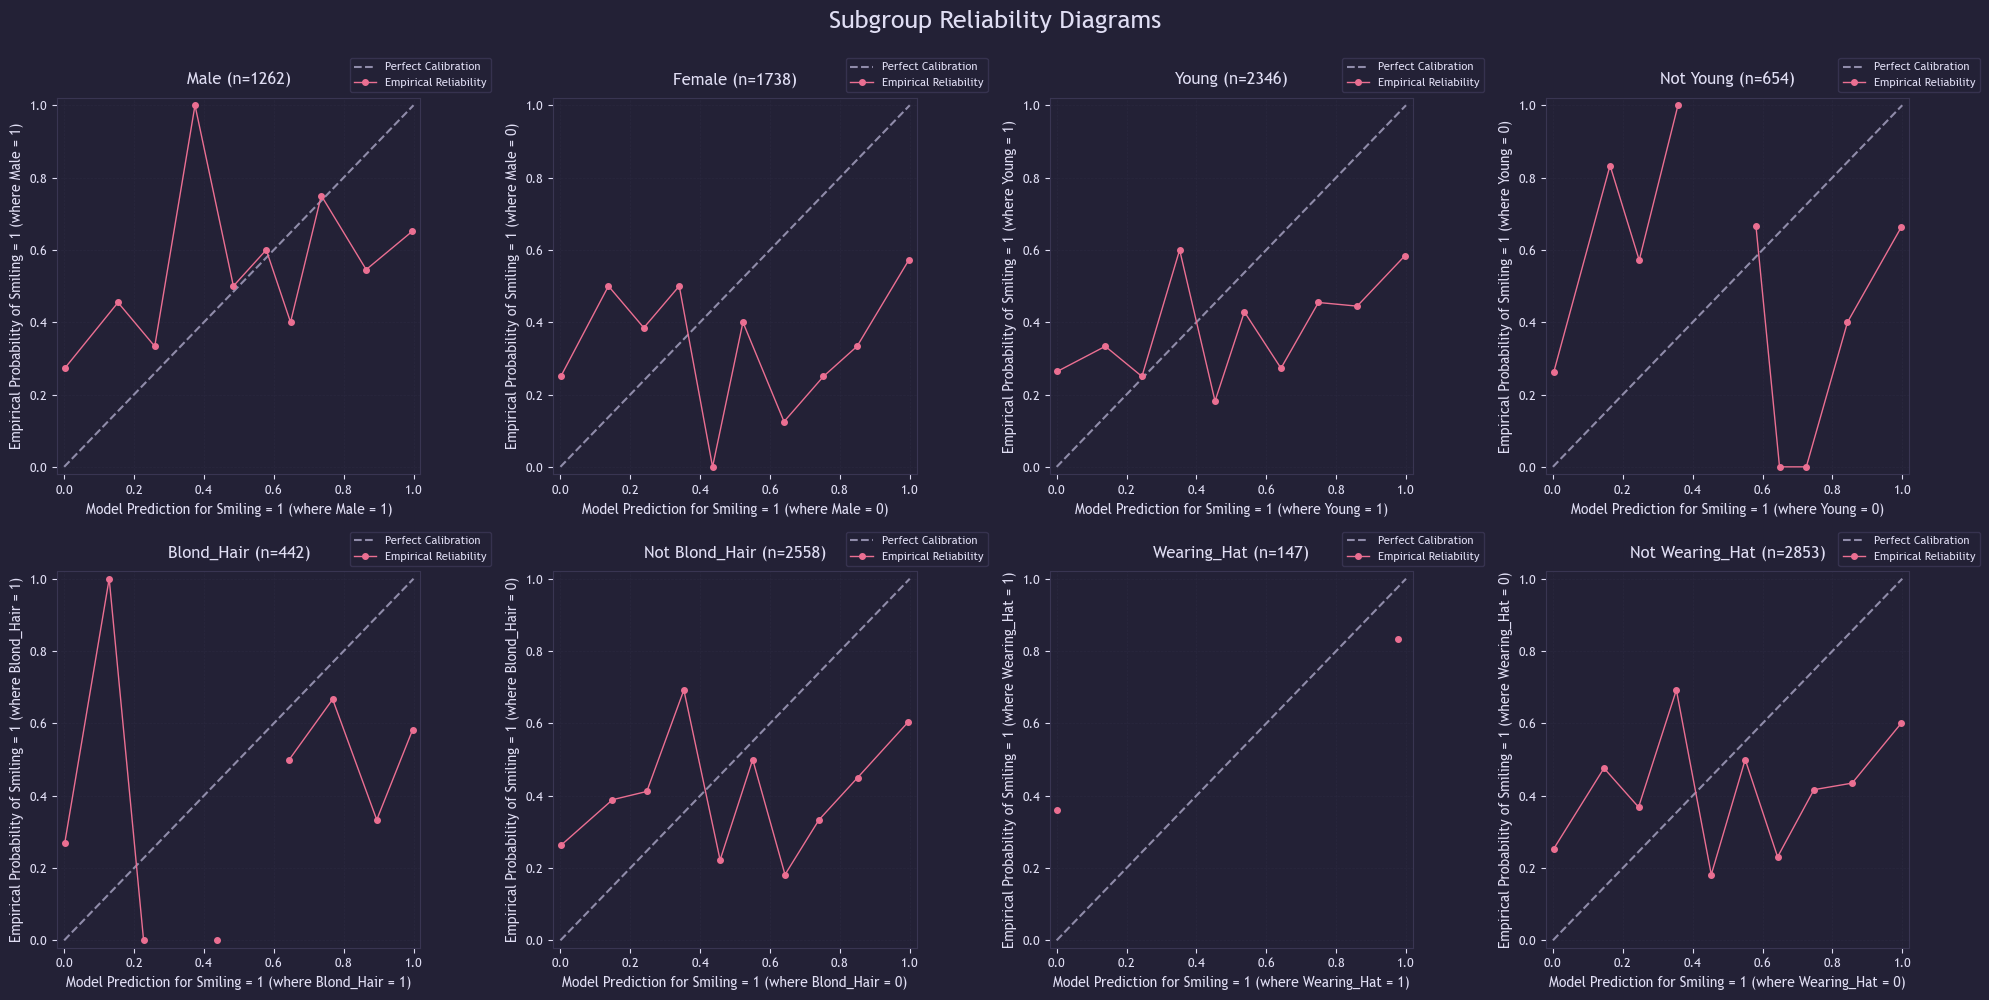

Subgroup,Size,Accuracy,ECE,MSE
Male,1262,0.6965,0.2908,0.2935
Female,1738,0.7100,0.2805,0.2801
Young,2346,0.7016,0.2878,0.2895
Not Young,654,0.7141,0.2742,0.2725
Blond_Hair,442,0.7285,0.2685,0.2672
Not Blond_Hair,2558,0.7002,0.2878,0.2890
Wearing_Hat,147,0.6463,0.3526,0.3525
Not Wearing_Hat,2853,0.7073,0.2811,0.2823
POPULATION,3000,0.7073,0.2811,0.2823


In [103]:
# First we setup our subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.patch.set_facecolor(COLOURS["background"])
fig.suptitle("Subgroup Reliability Diagrams", fontsize=18, color=COLOURS["text"], y=0.995)

axes = axes.flatten()

# Initialise list to store metrics for each group
results = []
plotIndex = 0

# Iterate over each subgroup
for name, info in SUBGROUPS.items():

    description = info["description"]
    mask = info["mask"]

    # Restrict subgroup mask to test set
    maskTest = mask.iloc[testIndex]
    subIndices = np.where(maskTest)[0]

    # Skip subgroup if no samples are present in the test set
    if len(subIndices) == 0:
        continue
    
    # Extract true labels and predicted probabilities for the subgroup
    yTrue = yTest[subIndices]
    yProb = pTest[subIndices]

    # Compute statistics for the subgroup
    accuracy = np.mean((yProb >= 0.5) == yTrue)
    ece = computeECE(yTrue, yProb)
    mse = computeMSE(yTrue, yProb)

    # Append results to dataframe for table
    results.append({
        "Subgroup": name,
        "Size": len(yTrue),
        "Accuracy": f"{accuracy:.4f}",
        "ECE": f"{ece:.4f}",
        "MSE": f"{mse:.4f}"
    })

    ax = axes[plotIndex]
    ax.set_facecolor(COLOURS["background"])

    accuracies, confidences = generateBins(yTrue, yProb)

    ax.plot([0,1], [0,1], label="Perfect Calibration", color=COLOURS["perfect"], linestyle="dashed")

    ax.plot(accuracies, confidences, marker="o", linestyle="-", color=COLOURS["empirical"], label="Empirical Reliability", markersize=4, linewidth=1)
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_xlabel("Model Prediction for Smiling = 1 (where " + description + ")", fontsize=10)
    ax.set_ylabel("Empirical Probability of Smiling = 1 (where " + description + ")", fontsize=10)
    ax.set_title(f"{name} (n={len(yTrue)})", fontsize=12, pad=10)
    
    # Set axis limits with margin
    margin = 0.02
    ax.set_xlim(-margin, 1 + margin)
    ax.set_ylim(-margin, 1 + margin)
    
    # Legend
    legend = ax.legend(loc='lower center', bbox_to_anchor=(1, 1), fontsize=8, frameon=True)
    legend.get_frame().set_facecolor(COLOURS['background'])
    legend.get_frame().set_edgecolor(COLOURS['grid'])
    legend.get_frame().set_alpha(0.9)
    
    ax.tick_params(which='both', labelsize=9)
    
    plotIndex += 1

plt.tight_layout()
plt.show()

results.append({
    "Subgroup": "POPULATION",
    "Size": len(yTest),
    "Accuracy": f"{accuracy:.4f}",
    "ECE": f"{ece:.4f}",
    "MSE": f"{mse:.4f}"
})

resultsDF = pd.DataFrame(results).to_html(index=False)

display(HTML(MESSAGE_PREFIX + "<h3>Summary Statistics Table</h3>" + resultsDF + MESSAGE_SUFFIX))

### C.2: Discussion

**Least Well Calibrated Subgroups**

From the summary table above, the subgroups with the highest ECE are:

- Not Young
- Blond_Hair
- Male

These subgroups have predictions that are overconfident, meaning that the model tends to assign probabilities that are too extreme relative to the actual outcomes.

Smaller subgroups suh as Wearing_Hat also show poor calibration, likely because fewer samples make the empirical estimate noisier.

**Does Overall Calibration Conceal Subgroup Differences?**

In summary, yes. Although the model is poorly calibrated overall, miscalibration is unevenly distributd across subgroups. Larger subgroups like Not Wearing_Hat and Not Blond_Hair contribute most to the population-level ECE, which can obscure the fact that smaller subgroups, such as Not Young are even worse calibrated. This shows that population-level metrics alone can hide subgroup-specific issues, an issue which multi-calibration aims to solve in section D.2.



## D: Improving Calibration and Multicalibration

### D.1: Post-hoc calibration

**Overview**:

This section evalutes the effect of global calibration on the Gaussian Naive Bayes Classifier using three methods: Linear Regression, Platt Scaling and Isotonic Regression. Calibration parameters are fitted on the calibration set to minimise MSE and predicted probabilities are clipped to [0, 1]. The calibrated predictions are then applied to the test set, and accuracy, ECE and MSE are recomputed for the population and 8 subgroups outlined in part C. Reliability diagrams visualise improvements in predicted probabilities vs. actual outcomes, highlighting whether global calibration improves subgroup-level reliability.

**Components Used**:

- `linearCalibration` **function**: Computes linear regression parameters for probabilitiy calibration.
- `CalibratedClassifierCV` **class*: Uses sklearns calibration classifier to apply platt scaling and isotonic regression.
- `computeECE`, `computeMSE` **functions**: Used again here to calculate the statistics of each calibration method.
- `generateBins` **function**: Required for plotting graphs.

First, a function is defined that will perform the linear regression on the dataset.

In [104]:
def linearRegression(pCalib, yCalib):
    """
    Performs the linear regression formula solution = (X^T X)^(-1) . X^T . y to
    the input parameters.

    Args:
        pCalib (ndarray): Predicted probabilities (shape: [n_samples]).
        yCalib (ndarray): True binary labels (0 or 1) (shape: [n_samples]).

    Returns:
        tuple: (gradient, intercept) of the fitted linear line.
    """

    # Need to add a column of 1's to pCalib matrix [p, 1]
    xLin = np.vstack([pCalib, np.ones_like(pCalib)]).T
    yLin = yCalib

    # Solve the matrix linear regression formula: solution = (X^T X)^(-1) . X^T . y (@ means matrix multiply)
    solution = np.linalg.inv(xLin.T @ xLin) @ (xLin.T @ yLin)

    return solution

Next, the function is used on the calibration set to give the parameters of the linear model, then the parameters are applied the test set. The plot is displayed showing pre and post calibration to highlight the difference.

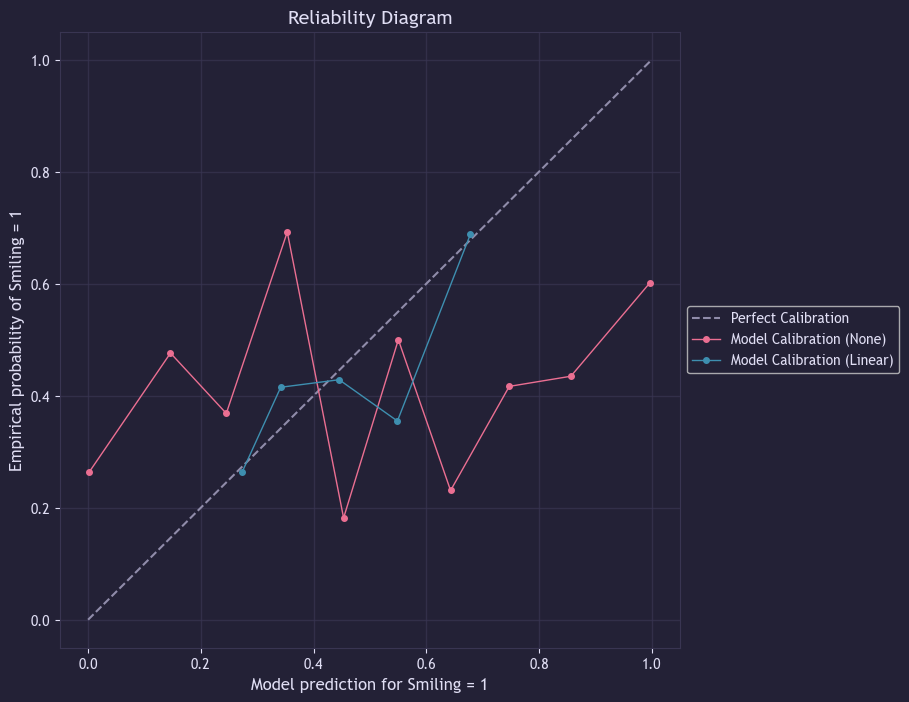

In [105]:
# Find calibration parameters from calibration set
gradient, yIntercept = linearRegression(pCalib, yCalib)

# Apply calibration to the test set and see how test set performs now
pTest = gnb.predict_proba(XTest)[:, 1]
linearProbs = np.clip(gradient * pTest + yIntercept, 0, 1)

# Get data for empirical reliability curve for pre-calibration test set
confidencesOld, accuraciesOld = generateBins(yTest, pTest)

# Get data for empirical reliability curve for post-calibration test set 
confidencesLinear, accuraciesLinear = generateBins(yTest, linearProbs)

# Plot the reliability diagram
plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1], label="Perfect Calibration", color=COLOURS["perfect"], linestyle="dashed")
plt.plot(confidencesOld, accuraciesOld, marker="o", linestyle="-", color=COLOURS["empirical"], label="Model Calibration (None)", markersize=4, linewidth=1)
plt.plot(confidencesLinear, accuraciesLinear, marker="o", linestyle="-", color=COLOURS["fit1"], label="Model Calibration (Linear)", markersize=4, linewidth=1)
plt.grid(True, alpha=0.7, linestyle="-", linewidth=1)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Model prediction for Smiling = 1")
plt.ylabel("Empirical probability of Smiling = 1")
plt.title("Reliability Diagram")
plt.show()

Now, the other two methods (Platt scaling and Isotonic regression) are applied to the original calibration set. The statistics on the test set are also displayed to show the quantative difference between the calibration methods on the population.

In [106]:
calibratorPlatt = CalibratedClassifierCV(FrozenEstimator(gnb), method="sigmoid")
calibratorPlatt.fit(XCalib, yCalib)
plattProbs = calibratorPlatt.predict_proba(XTest)[:, 1]

calibratorIso = CalibratedClassifierCV(FrozenEstimator(gnb), method='isotonic')
calibratorIso.fit(XCalib, yCalib)
isoProbs = calibratorIso.predict_proba(XTest)[:, 1]


results = {
    "Calibration Classifier": ["None", "Linear", "Platt", "Isotonic"],
    "ECE": [f"{computeECE(yTest, pTest):.4f}", f"{computeECE(yTest, linearProbs):.4f}", f"{computeECE(yTest, plattProbs):.4f}", f"{computeECE(yTest, isoProbs):.4f}"],
    "MSE": [f"{computeMSE(yTest, pTest):.4f}", f"{computeMSE(yTest, linearProbs):.4f}", f"{computeMSE(yTest, plattProbs):.4f}", f"{computeMSE(yTest, isoProbs):.4f}"]
}

resultsDF = pd.DataFrame(results).to_html(index=False)
display(HTML(MESSAGE_PREFIX + resultsDF + MESSAGE_SUFFIX))

Calibration Classifier,ECE,MSE
None,0.2846,0.2858
Linear,0.0129,0.2059
Platt,0.0117,0.2059
Isotonic,0.0268,0.1945


In the below example, the Platt calibration data is used to display the new reliability of the subgroups.

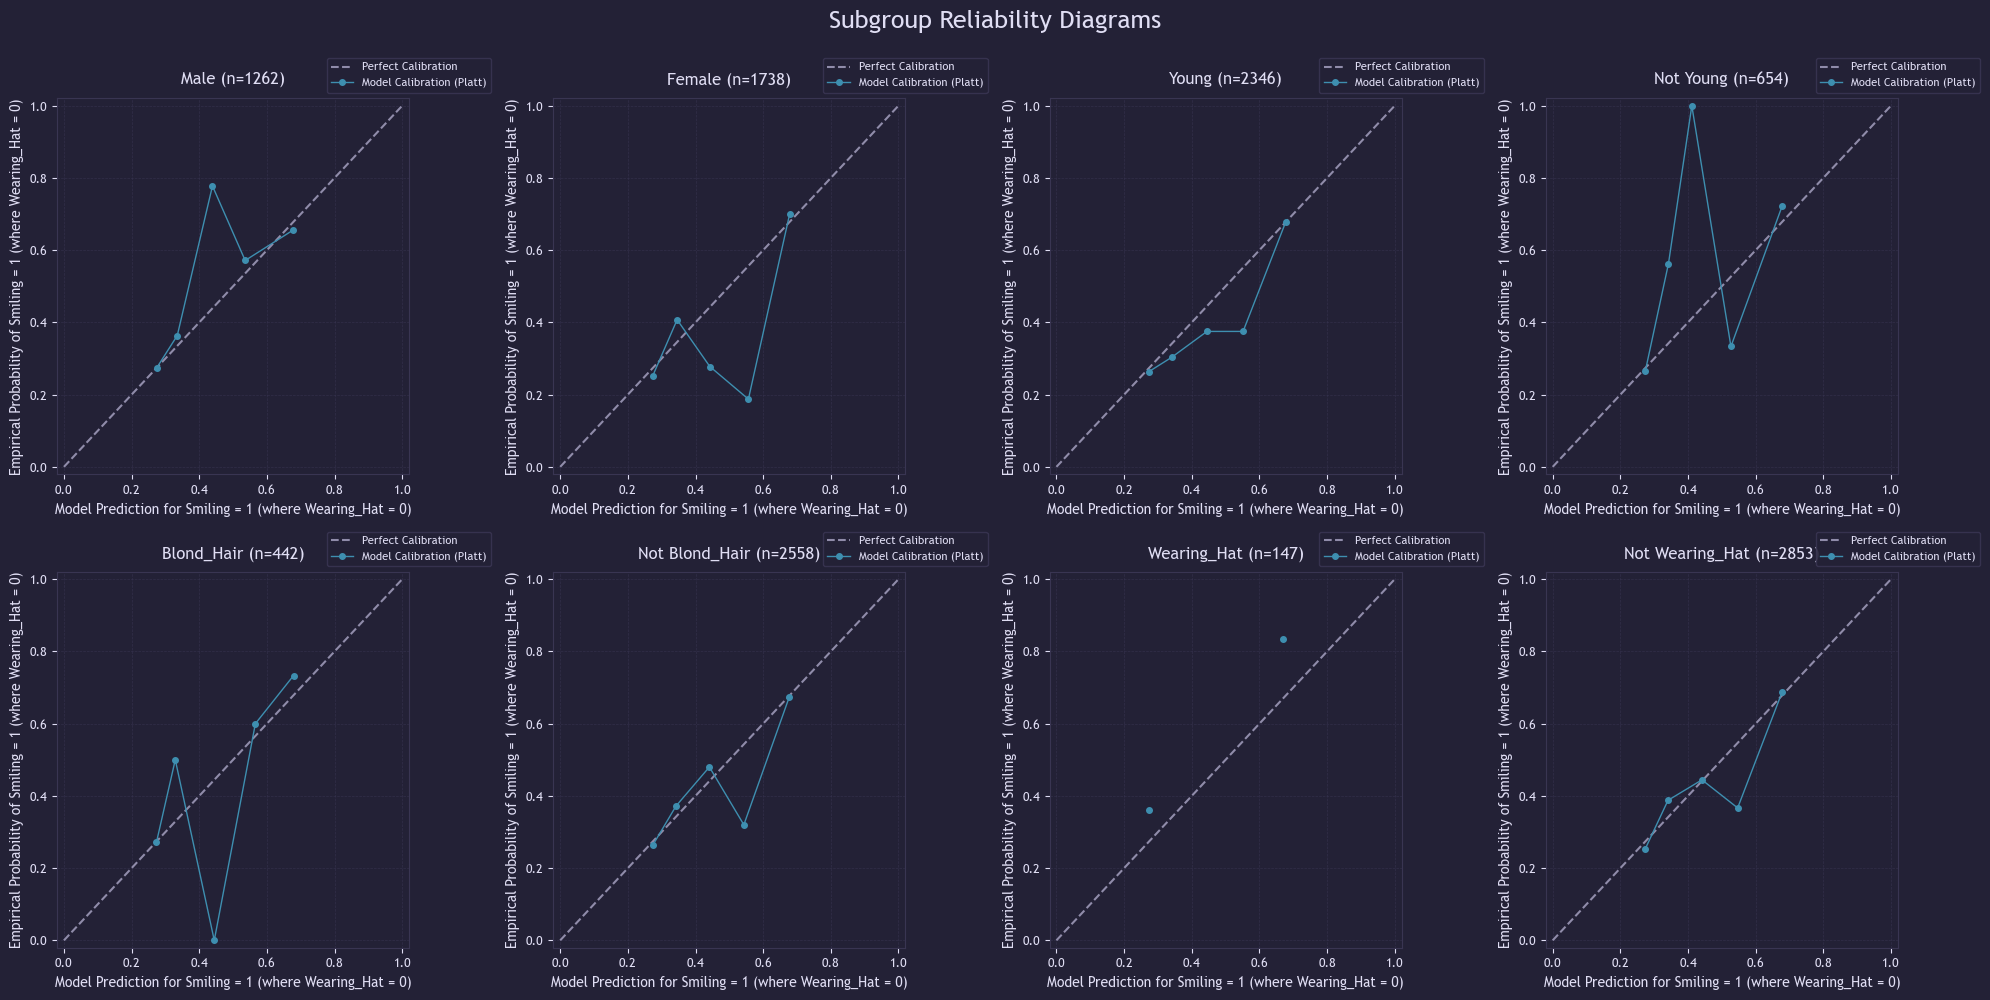

Subgroup,Size,Accuracy (Uncal),Accuracy (Cal),ECE (Uncal),ECE (Cal),MSE (Uncal),MSE (Cal),ECE % Change,MSE % Change
Male,1262,0.6965,0.6965,0.2908,0.0106,0.2935,0.2090,-96.3378,-28.8066
Female,1738,0.7100,0.7106,0.2805,0.0268,0.2801,0.2037,-90.4332,-27.2697
Young,2346,0.7016,0.7020,0.2878,0.0079,0.2895,0.2071,-97.2605,-28.4533
Not Young,654,0.7141,0.7141,0.2742,0.0345,0.2725,0.2018,-87.4152,-25.9547
Blond_Hair,442,0.7285,0.7285,0.2685,0.0439,0.2672,0.1996,-83.6372,-25.3003
Not Blond_Hair,2558,0.7002,0.7005,0.2878,0.0094,0.2890,0.2070,-96.7188,-28.3546
Wearing_Hat,147,0.6463,0.6463,0.3526,0.0915,0.3525,0.2354,-74.0616,-33.2284
Not Wearing_Hat,2853,0.7073,0.7077,0.2811,0.0164,0.2823,0.2044,-94.1727,-27.5931


In [107]:
# First we setup our subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.patch.set_facecolor(COLOURS["background"])
fig.suptitle("Subgroup Reliability Diagrams", fontsize=18, color=COLOURS["text"], y=0.995)

axes = axes.flatten()

# Initialise list to store metrics for each group
resultsCalibrated = []
plotIndex = 0

# Iterate over each subgroup
for name, info in SUBGROUPS.items():
    
    mask = info["mask"]

    # Restrict subgroup mask to test set
    maskTest = mask.iloc[testIndex]
    subIndices = np.where(maskTest)[0]
    
    # Skip subgroup if no samples are present in the test set
    if len(subIndices) == 0:
        continue
    
    # Extract true labels and CALIBRATED predicted probabilities for the subgroup
    yTrue = yTest[subIndices]
    yProbUnCalib = pTest[subIndices]  # Original probabilities
    yProbCalibPLatt = plattProbs[subIndices]  # Calibrated probabilities
    yProbCalibIso = isoProbs[subIndices]

    # Compute statistics for the subgroup with CALIBRATED probabilities
    accuracyCalib = np.mean((yProbCalibPLatt >= 0.5) == yTrue)
    ECECalib = computeECE(yTrue, yProbCalibPLatt)
    MSECalib = computeMSE(yTrue, yProbCalibPLatt)
    
    # Also compute for uncalibrated (for comparison)
    accuracyUnCalib = np.mean((yProbUnCalib >= 0.5) == yTrue)
    ECEUnCalib = computeECE(yTrue, yProbUnCalib)
    MSEUnCalib = computeMSE(yTrue, yProbUnCalib)
    
    # Generate data for plotting
    accuraciesPlatt, confidencesPlatt = generateBins(yTrue, yProbCalibPLatt)

    # Append results to dataframe for table
    resultsCalibrated.append({
        "Subgroup": name,
        "Size": len(yTrue),
        "Accuracy (Uncal)": f"{accuracyUnCalib:.4f}",
        "Accuracy (Cal)": f"{accuracyCalib:.4f}",
        "ECE (Uncal)": f"{ECEUnCalib:.4f}",
        "ECE (Cal)": f"{ECECalib:.4f}",
        "MSE (Uncal)": f"{MSEUnCalib:.4f}",
        "MSE (Cal)": f"{MSECalib:.4f}",
        "ECE % Change": f"{(ECECalib - ECEUnCalib) * 100 / ECEUnCalib:+.4f}",
        "MSE % Change": f"{(MSECalib - MSEUnCalib) * 100 / MSEUnCalib:+.4f}"
    })
    
    # Setup axes and graph
    ax = axes[plotIndex]
    ax.set_facecolor(COLOURS["background"])
    ax.grid(True, alpha=0.7, linestyle='--', linewidth=0.5)
    ax.set_xlabel("Model Prediction for Smiling = 1 (where " + description + ")", fontsize=10)
    ax.set_ylabel("Empirical Probability of Smiling = 1 (where " + description + ")", fontsize=10)
    ax.set_title(f"{name} (n={len(yTrue)})", fontsize=12, pad=10)
    
    # Set axis limits with margin
    margin = 0.02
    ax.set_xlim(-margin, 1 + margin)
    ax.set_ylim(-margin, 1 + margin)
    
    # Display actual plots
    ax.plot([0,1], [0,1], label="Perfect Calibration", color=COLOURS["perfect"], linestyle="dashed")
    ax.plot(accuraciesPlatt, confidencesPlatt, marker="o", linestyle="-", color=COLOURS["fit1"], label="Model Calibration (Platt)", markersize=4, linewidth=1)

    # Legend
    legend = ax.legend(loc='lower center', bbox_to_anchor=(1, 1), fontsize=8, frameon=True)
    legend.get_frame().set_facecolor(COLOURS['background'])
    legend.get_frame().set_edgecolor(COLOURS['grid'])
    legend.get_frame().set_alpha(0.9)
    
    ax.tick_params(which='both', labelsize=9)
    
    plotIndex += 1

plt.tight_layout()
plt.show()

display(HTML(MESSAGE_PREFIX + pd.DataFrame(resultsCalibrated).to_html(index=False) + MESSAGE_SUFFIX))

**Analysis of Subgroup Calibration After Global Calibration**

Accuracy

- Accuracy changes very little after calibration e.g., for most subgroups there is slight improvement but some see a negligible decrease. 
- This is expected because calibration adjusts probabilities, not the predicted class labels (unless a threshold change is involved which here it isn't).

ECE

- Calibration dramatically decreases ECE across all subgroups.
- Even in small subgroups like Wearing_Hat show substantial improvement.
- THis indicates global calibration significantly improves reliability for all subgroups, not just the population average.

MSE

- MSE also decreases consistently after calibration, although not by as much as ECE.
- This shows that adjusting probabilities closer to the true liklihoods reduces overall squared error.

To summarise, in this case global calibration does improve subgroup calibration. This is likely because the miscalibration in this dataset is largely systematic overconfidence, which a simple linear adjustment can correct for all groups. To be clear, this may not always happen if different subgroups have different patterns of miscalibration e.g., overconfident for some and underconfident for others.

### D.2: Multicalibration

**Overview**:


**Components Used:**

To help with the algorithm, a DummyEstimator class needs to be made to fit calibration to the data.

In [108]:
class DummyEstimator:
    """
    A dummy classifier that returns given probabilities as-is for calibration purposes.
    """
    _estimator_type = "classifier"


    def __init__(self, probs):
        self.probs = probs
        self.classes_ = np.array([0, 1])

    def _more_tags(self):
        """
        Provide additional tags for sklearn"s estimator checks.
        """
        return {"requires_y": True}

    def fit(self, X, y):
        # For compatibility with scikit-learn
        self.classes_ = np.array([0, 1])
        return self

    def predict_proba(self, X):
        # Return the same probabilities that were passed in
        return np.column_stack([1 - self.probs.flatten(), self.probs.flatten()])

    def predict(self, X):
        # Return class labels according to probability threshold 0.5
        return (self.probs.flatten() >= 0.5).astype(int)


The multiCalibrate function can now be created.

In [109]:
def iterativeMulticalibration(yTest, pInit, testIndex, groups=SUBGROUPS, maxIterations=5, ECEThreshold=0.03):
    """
    Perform iterative multicalibration over predefined subgroups.

    Args:
        yTest (ndarray): True binary labels for the test set, aligned with `testIndex`.
        pInit (ndarray): Initial predicted probabilities, used as starting point for calibration.
        testIndex (ndarray): Indices selecting the portion of the dataset that issued for testing.
        groups (dict) : Dictionary mapping subgroup names to metadata dictionaries.
        maxIterations (int): Maximum number of multicalibration rounds.
        ECEThreshold (float):  Early stopping criteria.
    """


    # Copy initial probabilities so we can iteratively update them
    pMultical = pInit.copy()

    # Store history of multicalibration progress
    history = {
        "iteration": [],
        "worstGroup": [],
        "worstECE": [],
        "populationECE": []
    }

    display(HTML(MESSAGE_PREFIX + f"Starting multicalibration (Target: ECE < {ECEThreshold})" + MESSAGE_SUFFIX))

    for i in range(maxIterations):
        
        interimResults = []
        groupECEs = {}

        # Compute subgroup ECEs
        for name, info in groups.items():
            
            mask = info["mask"]
            maskTest = mask.iloc[testIndex]
            subIndices = np.where(maskTest)[0]

            if len(subIndices) == 0:
                continue

            yTrue = yTest[subIndices]
            yProb = pMultical[subIndices]

            ece = computeECE(yTrue, yProb)

            # Store ECE and indices for later worst-group selection
            groupECEs[name] = (ece, subIndices)

            # Results table for display
            interimResults.append({
                "Subgroup": name,
                "ECE": f"{ece:.4f}",
                "Size": f"{len(subIndices)}"
            })

        # Identify worst-calibrated subgroup
        worstGroup = max(groupECEs.keys(), key=lambda g: groupECEs[g][0])
        worstECE, worstIndices = groupECEs[worstGroup]

        # Population-wide ECE for tracking
        popECE = computeECE(yTest, pMultical)

        # Save to history
        history["iteration"].append(i + 1)
        history["worstGroup"].append(worstGroup)
        history["worstECE"].append(worstECE)
        history["populationECE"].append(popECE)

        # Stop if all groups are below threshold
        if worstECE < ECEThreshold:
            display(HTML(MESSAGE_PREFIX + f"All groups have ECE < {ECEThreshold}. Stopping early." + MESSAGE_SUFFIX))
            break

        # Recalibrate only the worst subgroup
        yWorst = yTest[worstIndices]
        pWorst = pMultical[worstIndices]

        # Dummy estimator simply returns the stored probabilities
        dummy = DummyEstimator(pWorst)

        # Platt scaling via CalibratedClassifierCV
        calibrator = CalibratedClassifierCV(FrozenEstimator(dummy), method="sigmoid")

        # Fit calibrator on subgroup
        calibrator.fit(pWorst, yWorst)

        # Recalibrated probabilities
        pWorstRecalibrated = calibrator.predict_proba(pWorst)[:, 1]

        # Update calibrated probabilities in main array
        pMultical[worstIndices] = pWorstRecalibrated

        # Compute post-calibration ECE
        newECE = computeECE(yWorst, pWorstRecalibrated)

        # Display iteration summary
        display(HTML(MESSAGE_PREFIX  
            + f"<h3>Iteration {i + 1}/{maxIterations}</h3>" 
            + pd.DataFrame(interimResults).to_html(index=False) + 
            f"<h3>Recalibrating group: {worstGroup}</h3>"
            + f"Group ECE after recalibration: {newECE:.4f}"
            + MESSAGE_SUFFIX
        ))

    display(HTML(MESSAGE_PREFIX + f"Multicalibration Complete" + MESSAGE_SUFFIX))
    
    return pMultical, history   

We can use the multicalibrate function to run the multicalibration algorithm to plot the evolution of the worst group.

Subgroup,ECE,Size
Male,0.0106,1262
Female,0.0268,1738
Young,0.0079,2346
Not Young,0.0345,654
Blond_Hair,0.0439,442
Not Blond_Hair,0.0094,2558
Wearing_Hat,0.0915,147
Not Wearing_Hat,0.0164,2853


Subgroup,ECE,Size
Male,0.0190,1262
Female,0.0334,1738
Young,0.0114,2346
Not Young,0.0376,654
Blond_Hair,0.0428,442
Not Blond_Hair,0.0141,2558
Wearing_Hat,0.0274,147
Not Wearing_Hat,0.0164,2853


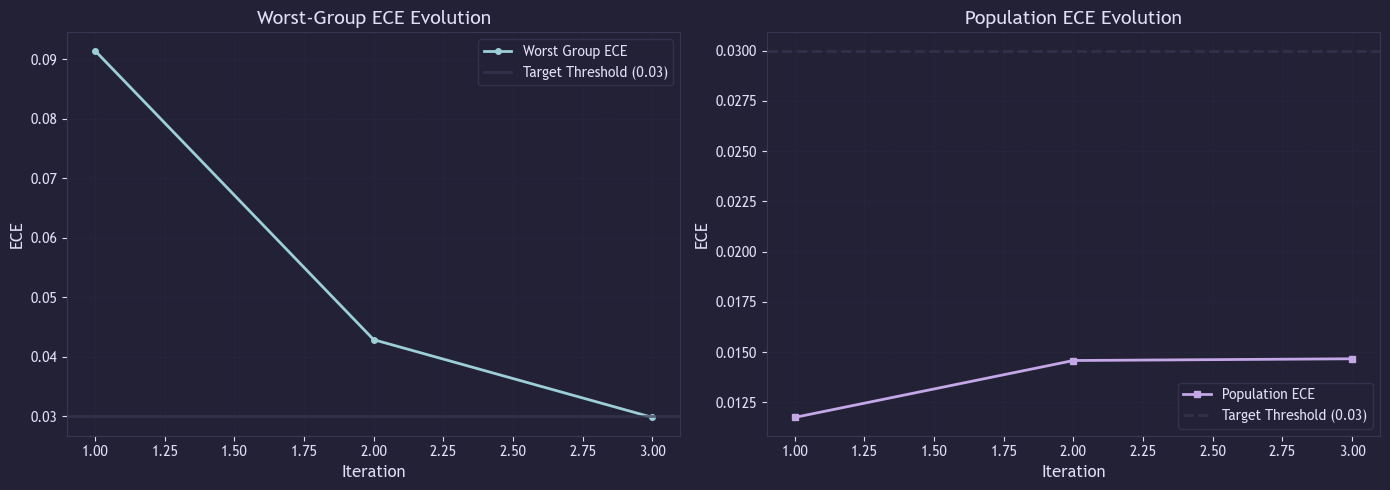

iteration,worstGroup,worstECE,populationECE
1,Wearing_Hat,0.091468,0.011748
2,Blond_Hair,0.042847,0.014579
3,Not Young,0.029776,0.014665


Group,Size,ECE (Global),ECE (Multi),ECE Δ,MSE (Global),MSE (Multi),MSE Δ
Male,1262,0.0106,0.0198,+0.0091,0.2090,0.2093,+0.0004
Female,1738,0.0268,0.0225,-0.0044,0.2037,0.2027,-0.0010
Young,2346,0.0079,0.0173,+0.0094,0.2071,0.2070,-0.0001
Not Young,654,0.0345,0.0298,-0.0047,0.2018,0.2002,-0.0016
Blond_Hair,442,0.0439,0.0243,-0.0197,0.1996,0.1980,-0.0016
Not Blond_Hair,2558,0.0094,0.0141,+0.0046,0.2070,0.2068,-0.0002
Wearing_Hat,147,0.0915,0.0221,-0.0694,0.2354,0.2319,-0.0035
Not Wearing_Hat,2853,0.0164,0.0153,-0.0011,0.2044,0.2041,-0.0003
POPULATION,3000,0.0117,0.0147,+0.0029,0.2059,0.2055,-0.0004


In [ ]:
pMultical, history = iterativeMulticalibration(yTest, plattProbs, testIndex)

# Plot the evolution of ECE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


for ax in [ax1, ax2]:
    fig.patch.set_facecolor(COLOURS["background"])
    ax.set_facecolor(COLOURS["background"])
    ax.spines["bottom"].set_color(COLOURS["grid"])
    ax.spines["top"].set_color(COLOURS["grid"])
    ax.spines["left"].set_color(COLOURS["grid"])
    ax.spines["right"].set_color(COLOURS["grid"])
    ax.tick_params(color=COLOURS["text"])
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5, color=COLOURS["grid"])

# Plot worst-group ECE
ax1.plot(history["iteration"], history["worstECE"], marker="o", markersize=4, linewidth=1, color=COLOURS["fit2"], label="Worst Group ECE")
ax1.axhline(y=0.03, color=COLOURS["grid"], linestyle="-", linewidth=2, alpha=0.7, label="Target Threshold (0.03)")
ax1.set_xlabel("Iteration", fontsize=12, color=COLOURS["text"])
ax1.set_ylabel("ECE", fontsize=12, color=COLOURS["text"])
ax1.set_title("Worst-Group ECE Evolution", fontsize=14, color=COLOURS["text"])
ax1.legend(frameon=True, facecolor=COLOURS["background"], edgecolor=COLOURS["grid"], labelcolor=COLOURS["text"])

# Plot population ECE
ax2.plot(history["iteration"], history["populationECE"], marker="s", markersize=4, linewidth=1, color=COLOURS["fit3"], label="Population ECE")
ax2.axhline(y=0.03, color=COLOURS["grid"], linestyle="--", linewidth=2, alpha=0.7, label="Target Threshold (0.03)")
ax2.set_xlabel("Iteration", fontsize=12, color=COLOURS["text"])
ax2.set_ylabel("ECE", fontsize=12, color=COLOURS["text"])
ax2.set_title("Population ECE Evolution", fontsize=14, color=COLOURS["text"])
ax2.legend(frameon=True, facecolor=COLOURS["background"], edgecolor=COLOURS["grid"], labelcolor=COLOURS["text"])

plt.tight_layout()
plt.show()

# Create summary table
summary_df = pd.DataFrame(history)
summary_html = summary_df.to_html(index=False)

display(HTML(MESSAGE_PREFIX + "<h3>Multicalibration History</h3>" + summary_html + MESSAGE_SUFFIX))

comparison_results = []

for name, info in SUBGROUPS.items():
    
    mask = info["mask"]
    maskTest = mask.iloc[testIndex]
    subIndices = np.where(maskTest)[0]
    if len(subIndices) == 0:
        continue
    
    yTrue = yTest[subIndices]
    pGlobal = plattProbs[subIndices]
    pMulti = pMultical[subIndices]
    
    eceGlobal = computeECE(yTrue, pGlobal)
    eceMulti = computeECE(yTrue, pMulti)
    mseGlobal = computeMSE(yTrue, pGlobal)
    mseMulti = computeMSE(yTrue, pMulti)
    
    comparison_results.append({
        "Group": name,
        "Size": len(yTrue),
        "ECE (Global)": f"{eceGlobal:.4f}",
        "ECE (Multi)": f"{eceMulti:.4f}",
        "ECE Δ": f"{eceMulti - eceGlobal:+.4f}",
        "MSE (Global)": f"{mseGlobal:.4f}",
        "MSE (Multi)": f"{mseMulti:.4f}",
        "MSE Δ": f"{mseMulti - mseGlobal:+.4f}"
    })

# Add population metrics
popECEGlobal = computeECE(yTest, plattProbs)
popECEMulti = computeECE(yTest, pMultical)
popMSEGlobal = computeMSE(yTest, plattProbs)
popMSEMulti = computeMSE(yTest, pMultical)

comparison_results.append({
    "Group": "POPULATION",
    "Size": len(yTest),
    "ECE (Global)": f"{popECEGlobal:.4f}",
    "ECE (Multi)": f"{popECEMulti:.4f}",
    "ECE Δ": f"{popECEMulti - popECEGlobal:+.4f}",
    "MSE (Global)": f"{popMSEGlobal:.4f}",
    "MSE (Multi)": f"{popMSEMulti:.4f}",
    "MSE Δ": f"{popMSEMulti - popMSEGlobal:+.4f}"
})

comparison_df = pd.DataFrame(comparison_results)
comparison_html = comparison_df.to_html(index=False)

display(HTML(MESSAGE_PREFIX + "<h3>Final Comparison Table</h3>" + comparison_html + MESSAGE_SUFFIX))